In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as pl

import theano
import theano.tensor as tt

from starry.kepler import Primary, Secondary, System

In [2]:
def build_system(star_u, planet_y, r, L, a, porb, prot, inc, ecc, w, lambda0):
    star = Primary(lmax=2)
    star[:] = star_u

    planet = Secondary(lmax=1)
    planet[1, :] = planet_y

    planet.r = r
    planet.L = L
    planet.a = a
    planet.porb = porb
    planet.prot = prot
    planet.inc = inc
    planet.ecc = ecc
    planet.w = w
    planet.lambda0 = lambda0
#     planet.lambda0 = 60.0
#     planet.tref = tref
    
    return star, planet, System(star, planet)

<Container object of 3 artists>

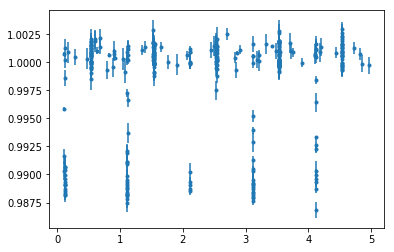

In [3]:
np.random.seed(1234)
period = 1.0
true_params = [
    [0.5, 0.25],
    [0.08682409, 0.47562562, 0.1274435],
    0.1,
    1.e-3,
    50.,
    period,
    period,
    89.5,
    0.25,
    120.,
    60.0,
]

star, planet, system = build_system(*true_params)

obs_t = np.random.uniform(0.114, 0.121, 101) + np.random.randint(5, size=101) * period
obs_t = np.append(obs_t, np.random.uniform(0.531, 0.541, 200) + np.random.randint(5, size=200) * period)
obs_t = np.sort(np.append(obs_t, np.random.uniform(0, 5, 50)))

system.compute(obs_t)
ferr = np.random.uniform(1e-4, 1e-3, len(obs_t))
obs_f = system.lightcurve + ferr * np.random.randn(len(obs_t))

pl.errorbar(obs_t, obs_f, yerr=ferr, fmt=".")
# pl.xlim(0.531, 0.534)
# pl.ylim(0.998, 1.002)

In [4]:
class StarryOp(tt.Op):
    
    def __init__(self):        
        # Star limb darkening
        itypes = [tt.dvector()]
        self.param_names = [["A.u_{1}", "A.u_{2}"]]
        
        # Planet hot spot
        itypes += [tt.vector()]
        self.param_names += [["b.Y_{1,-1}", "b.Y_{1,0}", "b.Y_{1,1}"]]
        
        # Planet orbital parameters
        itypes += [tt.dscalar() for i in range(9)]
        self.param_names += [[n] for n in ["b.r", "b.L", "b.a", "b.porb", "b.prot", "b.inc", "b.ecc", "b.w", "b.lambda0"]]

        # Times
        itypes += [tt.dvector()]
        self.param_names += [["time"]]
                
        self.itypes = tuple(itypes)
        
        # Output will always be a vector
        self.otypes = tuple([tt.dvector()])
        
        self._grad_op = StarryGradOp(self)
        
    def make_node(self, *args):
        args = [tt.as_tensor_variable(a) for a in args]
        return theano.Apply(self, args, [args[-1].type()])
        
    def infer_shape(self, node, shapes):
        """A required method that returns the shape of the output"""
        return shapes[-1],

    def perform(self, node, inputs, outputs):
        """A required method that actually executes the operation"""
        star, planet, system = build_system(*(inputs[:-1]))
        system.compute(np.array(inputs[-1]))       
        outputs[0][0] = np.array(system.lightcurve)
        
    def grad(self, inputs, gradients):
        return self._grad_op(*(inputs + gradients))

        
class StarryGradOp(tt.Op):
    
    def __init__(self, base_op):
        self.base_op = base_op

        # This operation will take the original inputs and the gradient
        # seed as input
        types = list(self.base_op.itypes)
        self.nout = len(self.base_op.otypes)
        self.itypes = tuple(types + list(self.base_op.otypes))
        self.otypes = tuple(types)
        
    def make_node(self, *args):
        args = [tt.as_tensor_variable(a) for a in args]
        return theano.Apply(self, args, [a.type() for a in args[:-self.nout]])
 
    def infer_shape(self, node, shapes):
        return shapes[:-self.nout]

    def perform(self, node, inputs, outputs):
        star, planet, system = build_system(*(inputs[:-self.nout-1]))
        system.compute(np.array(inputs[-self.nout-1]), gradient=True)     
        grads = system.gradient

        try:
            for i, param in enumerate(self.base_op.param_names):
                if len(param) > 1:
                    g = []
                    for j, name in enumerate(param):
                        g.append(np.sum(np.array(grads[name]) * np.array(inputs[-1])))
                    outputs[i][0] = np.squeeze(g)
                else:
                    if param[0] == "time":
                        outputs[i][0] = np.array(grads[param[0]]) * np.array(inputs[-1])
                    else:
                        outputs[i][0] = np.array(np.sum(np.array(grads[param[0]]) * np.array(inputs[-1])))
        except:
            print(grads.keys())
            raise

In [5]:
starry_op = StarryOp()

star_u = tt.dvector()
planet_y = tt.dvector()

r = tt.dscalar()
L = tt.dscalar()
a = tt.dscalar()
porb = tt.dscalar()
prot = tt.dscalar()
inc = tt.dscalar()
ecc = tt.dscalar()
w = tt.dscalar()
lambda0 = tt.dscalar()

time = tt.dvector()

args = (star_u, planet_y,
        r, L, a, porb, prot, inc, ecc, w, lambda0,
        time)

lc = starry_op(*args)

f = theano.function(args, lc)
g = theano.function(args, theano.grad(tt.sum(lc), args))

result = g(*(true_params + [obs_t]))

In [6]:
# from theano.tests import unittest_tools as utt

# pt = true_params + [obs_t]

# utt.verify_grad(op, pt, )

In [15]:
import pymc3 as pm

with pm.Model() as model:
    q1 = (true_params[0][0] + true_params[0][1])**2
    q2 = 0.5 * true_params[0][0] / (true_params[0][0] + true_params[0][1])
    star_q = pm.Uniform("q", lower=0.0, upper=1.0, shape=(2,),
                        testval=np.array([q1, q2]))
    star_u = tt.stack([
        2.0 * tt.sqrt(star_q[0]) * star_q[1],
        tt.sqrt(star_q[0]) * (1.0 - 2.0 * star_q[1]),
    ])
    
    pm.Deterministic("u", star_u)
    
    y_param = pm.Normal("yparam", shape=(3,), testval=true_params[1])
    y_scale = pm.Uniform("yscale", lower=0.0, upper=1.0/np.sqrt(3), testval=np.sqrt(np.sum(np.array(true_params[1])**2)))
    planet_y = y_scale * y_param / tt.sqrt(tt.sum(y_param**2))
    pm.Deterministic("py", planet_y)
    
    pm.Potential("yprior", 0.5*tt.log(tt.sum(planet_y**2)))
    
    logr = pm.Uniform("logr", lower=np.log(0.05), upper=np.log(0.5), testval=np.log(true_params[2]))
    logL = pm.Uniform("logL", lower=np.log(1e-6), upper=np.log(1.0), testval=np.log(true_params[3]))
    loga = pm.Uniform("loga", lower=np.log(10.0), upper=np.log(100.0), testval=np.log(true_params[4]))
    logporb = pm.Uniform("logporb", lower=np.log(0.1), upper=np.log(10.0), testval=np.log(true_params[5]))
    logprot = pm.Uniform("logprot", lower=np.log(0.1), upper=np.log(10.0), testval=np.log(true_params[6]))
    inc = pm.Uniform("inc", lower=0.0+1e-5, upper=90.0-1e-5, testval=true_params[7])
    ecc = pm.Uniform("ecc", lower=0.0, upper=0.5, testval=true_params[8])
    w = pm.Uniform("w", lower=0.0, upper=360.0, testval=true_params[9])
    t0 = pm.Uniform("t0", lower=-0.5, upper=0.5, testval=0.1173)
    
    f0 = 0.5*np.pi - np.pi * w / 180.0
    E0 = 2.0 * tt.arctan2(tt.sqrt(1.0 - ecc) * tt.tan(0.5*f0),
                          tt.sqrt(1.0 + ecc))
    M0 = E0 - ecc*tt.sin(E0)
    lambda0 = 180.*(M0 - 2*np.pi*t0*tt.exp(-logporb))/np.pi + w
        
#     lambda0 = pm.Uniform("lambda0", lower=0.0, upper=360.0, testval=true_params[10])
    
#     logL = np.log(true_params[3])
#     loga = np.log(true_params[4])
#     logporb = np.log(true_params[5])
#     logprot = np.log(true_params[6])
#     inc = np.float64(true_params[7])
#     ecc = np.float64(true_params[8])
#     w = np.float64(true_params[9])
#     lambda0 = np.float64(true_params[10])
    
    lc = starry_op(star_u, planet_y,
                   tt.exp(logr), tt.exp(logL),
                   tt.exp(loga), tt.exp(logporb),
                   tt.exp(logprot),
                   inc, ecc, w,
                   lambda0, obs_t)
    
    pm.Deterministic("lc", lc)
    pm.Normal("obs", mu=lc, sd=ferr, observed=obs_f)

    soln = pm.find_MAP()
#     trace = pm.sample(draws=500, tune=500)

logp = 2,155.7, ||grad|| = 7,762.3: 100%|██████████| 48/48 [00:00<00:00, 107.56it/s]  


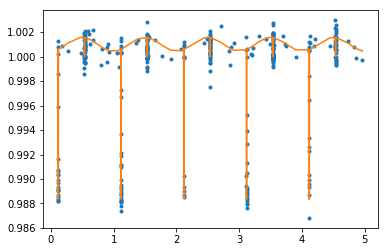

In [16]:
pl.plot(obs_t, obs_f, ".")
pl.plot(obs_t, soln["lc"])

In [17]:
with model:
    trace = pm.sample(draws=1000, tune=1000, start=soln)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t0, w, ecc, inc, logprot, logporb, loga, logL, logr, yscale, yparam, q]
Sampling 4 chains: 100%|██████████| 8000/8000 [3:10:37<00:00,  3.37s/draws]
The acceptance probability does not match the target. It is 0.8788571946968718, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


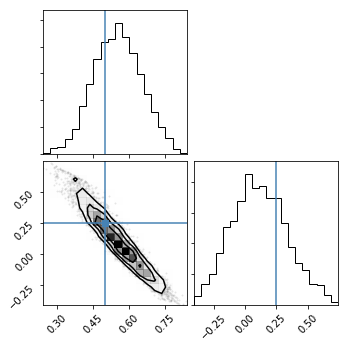

In [18]:
import corner
samples = trace["u"]
corner.corner(samples, truths=true_params[0]);

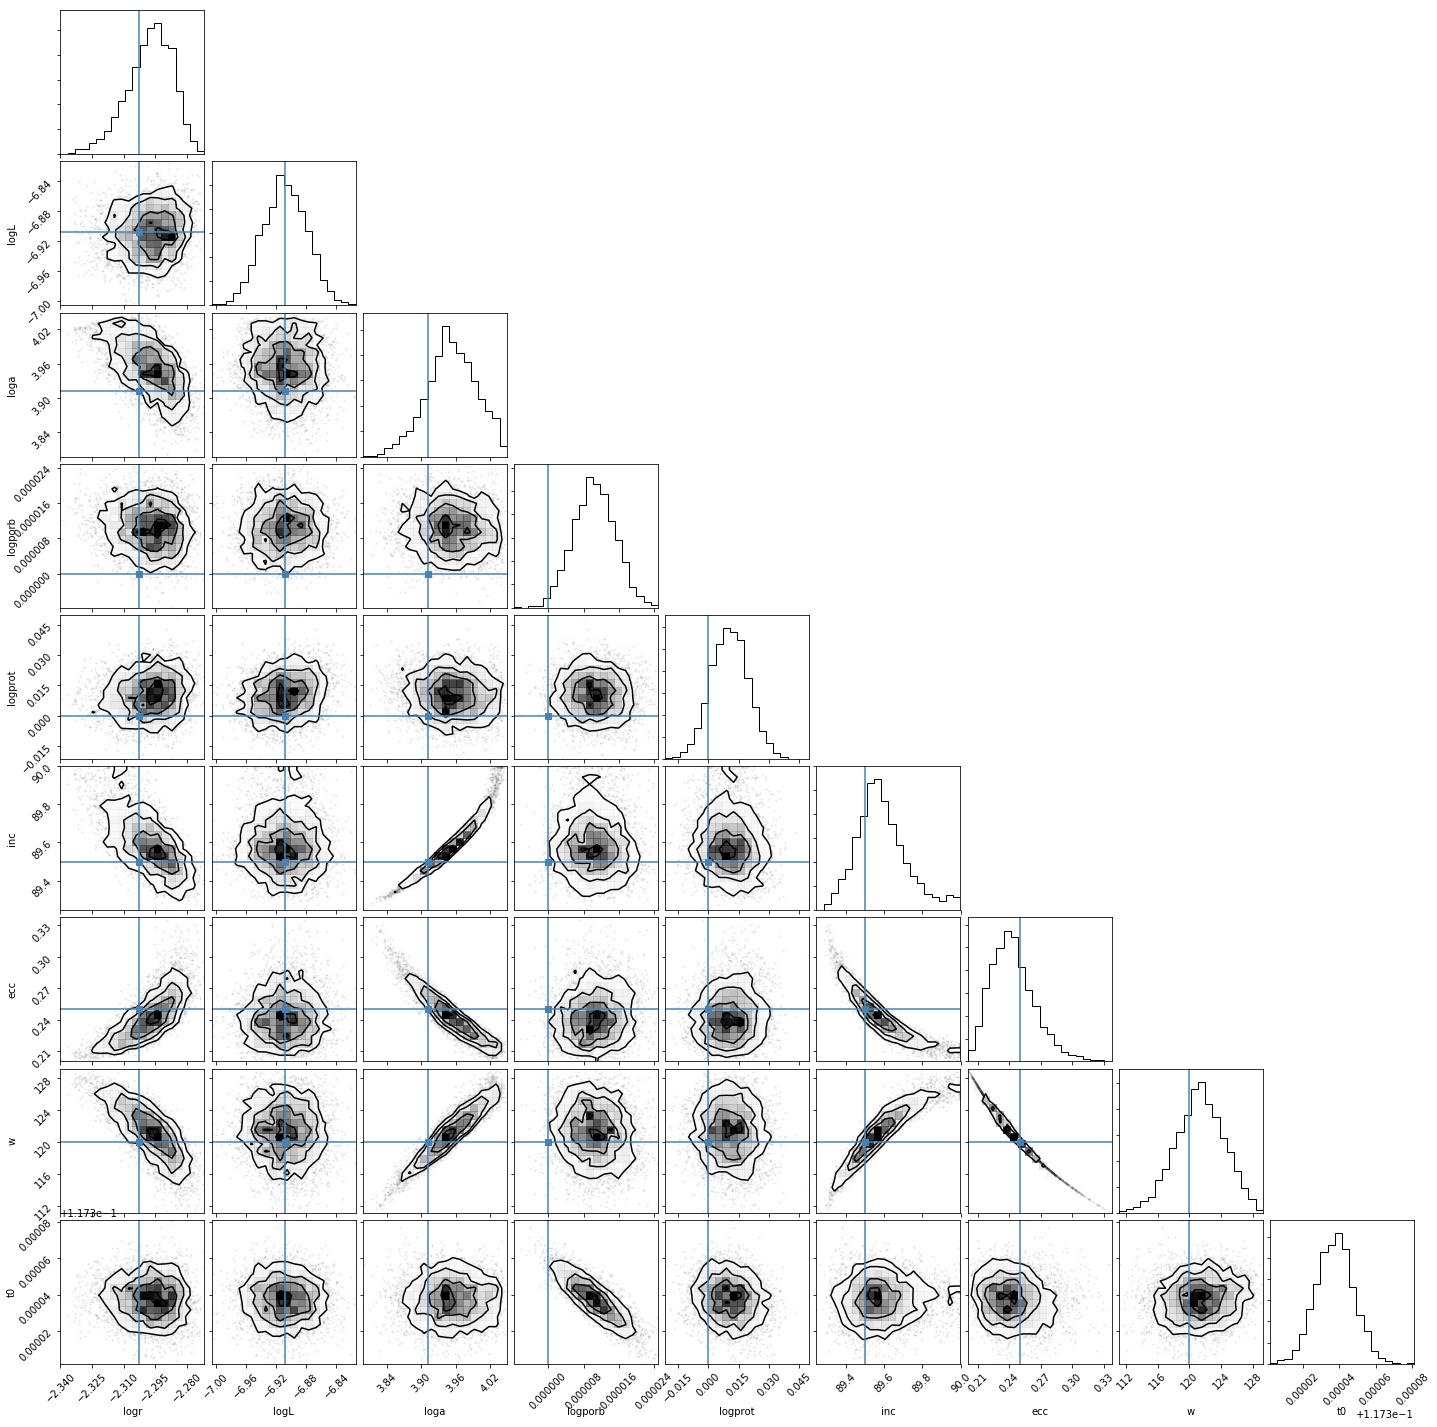

In [19]:
names = ["logr", "logL", "loga", "logporb", "logprot", "inc", "ecc", "w", "t0"]
truths = np.append(np.log(true_params[2:-4]), true_params[-4:])
samples = np.vstack([trace[k] for k in names]).T
corner.corner(samples, labels=names, truths=truths);

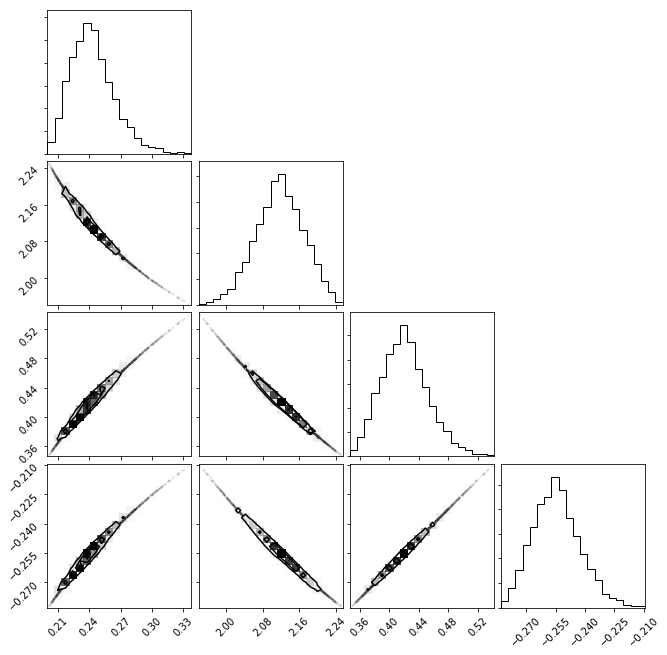

In [26]:
e = trace["ecc"]
# n = 2*np.pi / np.exp(trace["logporb"])
w = np.radians(trace["w"])
# l = np.radians(trace["lambda0"])

# M0 = l - w
# f0 = 0.5*np.pi - w
# E0 = 2.0 * np.arctan2(np.sqrt(1.0 - e) * np.tan(0.5*f0),
#                       np.sqrt(1.0 + e))
# M = E0 - e*np.sin(E0)
# t0 = (M - M0) / n

samples = np.vstack((e, w, np.sqrt(e)*np.sin(w), np.sqrt(e) * np.cos(w),
                    )).T
corner.corner(samples);

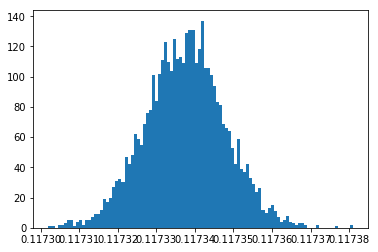

In [23]:
pl.hist(trace["t0"], 100);

(0.1, 0.2)

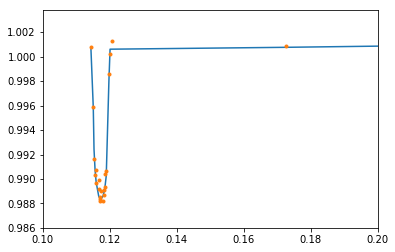

In [24]:
pl.plot(obs_t, soln["lc"])
pl.plot(obs_t, obs_f, ".")
pl.xlim(0.1, 0.2)

In [25]:
x, y = w, tref
i = np.argsort(x)
pl.plot(x[i], y[i])

p = np.polyfit(x, y, 2)
print(p)
mod = np.polyval(p, x[i])
pl.plot(x[i], mod);

pl.figure()
pl.plot(x[i], y[i] - mod)

NameError: name 'tref' is not defined

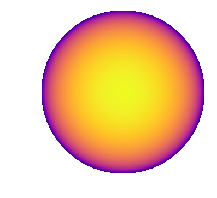

In [6]:
star = Primary(lmax=2)
star[1] = 0.5
star[2] = 0.25
star.show()

[1.         0.08682409 0.47562562 0.1274435 ]


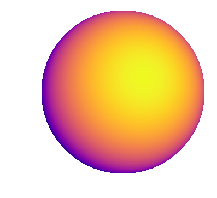

In [19]:
planet = Secondary(lmax=1)
scale = 0.5
lat = 10
lon = 15
planet[1, 0] = scale
planet.axis = [1, 0, 0]
planet.rotate(-lat)
planet.axis = [0, 1, 0]
planet.rotate(lon)
print(planet[:,:])
planet.show()

In [ ]:
planet.r = 0.1
planet.L = 1.e-3
planet.a = 50
planet.porb = 1
planet.prot = 1
planet.inc = 89.5
planet.ecc = 0.25
planet.w = 120
planet.lambda0 = 60

planet.tref = 0
planet.Omega = 0

In [25]:
repr(np.random.randn(5))

'array([-0.32666347,  0.29517146,  0.78762312,  0.67962602,  0.21158543])'